# Лабораторная работа 8. Методы снижения размерности

In [2]:
import umap
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.datasets import load_iris, load_wine, fetch_california_housing, fetch_openml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from scipy.stats import spearmanr

from matplotlib import pyplot

## Линейные методы

### Задание 1. Применение метода главных компонент(PCA).
Используйте набор данных "Iris" из sklearn.datasets. Примените PCA, чтобы снизить размерность до 2-х и визуализируйте результаты.

In [3]:
ds_iris = load_iris()

df_iris = pd.DataFrame(data=ds_iris.data, columns=ds_iris.feature_names)
df_iris['target'] = ds_iris.target_names[ds_iris.target[:, None]]

df_iris.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa


In [4]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
df_iris.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

In [6]:
df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
def anomalies_to_mean(df, target):
    for col in df.drop(columns=[target]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1 

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df[col] = df[col].apply(lambda x: df[col].mean() if x < lower_bound or x > upper_bound else x)

anomalies_to_mean(df_iris, 'target')

df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.040862,3.758000,1.199333
std,0.828066,0.392486,1.765298,0.762238
min,4.300000,2.200000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.000000,6.900000,2.500000


In [8]:
X, y = df_iris.drop(columns=['target']), df_iris.target

X = StandardScaler().fit_transform(X)


In [9]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

df_pca = pd.DataFrame(data = principalComponents, columns = ['PCA component 1', 'PCA component 2'])
df_pca['target'] = df_iris['target']

df_pca.head(7)

,PCA component 1,PCA component 2,target
0,-2.297360,0.652041,setosa
1,-2.097441,-0.627216,setosa
2,-2.388919,-0.233634,setosa
3,-2.321113,-0.511264,setosa
4,-2.426582,0.849630,setosa
5,-2.120063,1.758363,setosa
6,-2.476141,0.214689,setosa


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_14688\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


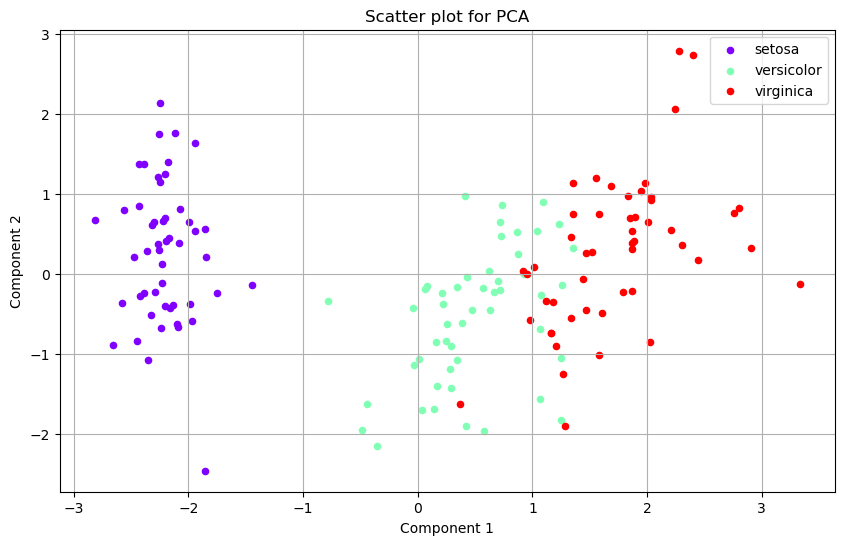

In [10]:
def visualize(method, df_method, ds_target, s_=20):
    plt.figure(figsize=(10,6))

    plt.title(f'Scatter plot for {method}')

    for target, color in zip(ds_target, cm.rainbow(np.linspace(0, 1, len(ds_target)))):
        x = df_method[df_method['target'] == target][f'{method} component 1']
        y = df_method[df_method['target'] == target][f'{method} component 2']

        plt.scatter(x, y, c=color, label=target, s=s_)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid()
    plt.legend()
    plt.show()  

visualize('PCA', df_pca, ds_iris.target_names)

### Задание 2. Сравнение PCA и Factor Analysis.
Используйте набор данных "Wine" из sklearn.datasets. Примените PCA и Factor Analysis, чтобы снизить размерность до 2-х и визуализируйте различия в результатах.

In [11]:
ds_wine = load_wine()

df_wine = pd.DataFrame(data=ds_wine.data, columns=ds_wine.feature_names)
df_wine['target'] = ds_wine.target_names[ds_wine.target[:, None]]

df_wine.head(7)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0,class_0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0,class_0


In [12]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [13]:
df_wine.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [14]:
df_wine.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [15]:
anomalies_to_mean(df_wine, 'target')

df_wine.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.280444,2.362526,19.384718,98.679586,2.295112,2.029270,0.361854,1.570235,4.912036,0.953222,2.611685,746.893258
std,0.811827,1.028666,0.247381,3.025508,12.246509,0.625851,0.998859,0.124453,0.537302,2.092561,0.221421,0.709990,314.907474
min,11.030000,0.740000,1.700000,11.200000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.212500,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.494944,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.960000,2.780000,673.500000
75%,13.677500,2.982500,2.540000,21.500000,106.000000,2.800000,2.875000,0.437500,1.942500,6.000000,1.120000,3.170000,985.000000
max,14.830000,5.190000,2.920000,27.000000,134.000000,3.880000,5.080000,0.660000,2.960000,10.520000,1.450000,4.000000,1680.000000


In [16]:
X, y = df_wine.drop(columns=['target']), df_wine['target']

X = StandardScaler().fit_transform(X)

In [17]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

df_pca = pd.DataFrame(data = principalComponents, columns = [f'PCA component {i}' for i in range(1,3)])
df_pca['target'] = df_wine['target']

df_pca.head(7)

,PCA component 1,PCA component 2,target
0,3.458787,-1.659801,class_0
1,2.369778,0.265602,class_0
2,2.582495,-1.021233,class_0
3,3.875298,-2.806904,class_0
4,0.973886,-1.113666,class_0
5,3.204874,-2.223475,class_0
6,2.586478,-1.143726,class_0


In [18]:
fa = FactorAnalysis(n_components=2)

factorComponents = fa.fit_transform(X)
df_fa = pd.DataFrame(data = factorComponents, columns = [f'Factor Analysis component {i}' for i in range(1,3)])
df_fa['target'] = df_wine['target']

df_fa.head(7)

,Factor Analysis component 1,Factor Analysis component 2,target
0,1.268752,0.733339,class_0
1,0.847183,-0.019125,class_0
2,1.169396,0.521381,class_0
3,1.699370,1.721892,class_0
4,0.617316,0.129478,class_0
5,1.366184,1.397605,class_0
6,0.804909,0.692462,class_0


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_14688\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


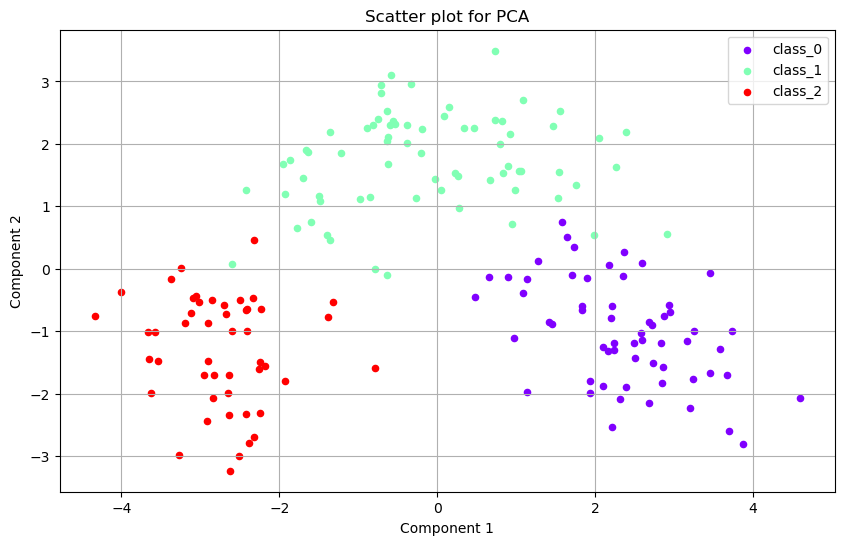

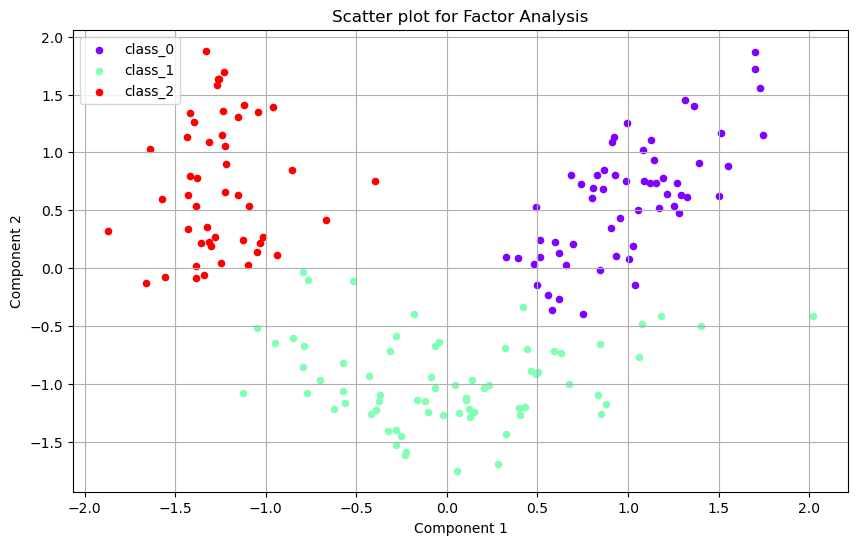

In [19]:
# for target in ds_wine.target_names:
#     plt.figure(figsize=(8,8))
    
#     plt.scatter(df_pca[df_pca['target'] == target]['principal component 1'], df_pca[df_pca['target'] == target]['principal component 2'], c='r', label='PCA')
#     plt.scatter(df_fa[df_fa['target'] == target]['factor component 1'], df_fa[df_fa['target'] == target]['factor component 2'], c='b', label='Factor Analysis')

#     plt.title(f'ScatterPlot for {target}')
#     plt.xlabel('Component 1')
#     plt.ylabel('Component 2')
#     plt.legend()
#     plt.grid()
#     plt.show()

visualize('PCA', df_pca, ds_wine.target_names)
visualize('Factor Analysis', df_fa, ds_wine.target_names)

### Задание 3. Исследование влияния предобработки даннхы на результаты PCA.
Используйте набор данных "Boston Housing" из sklearn.datasets. Примените различные методы предобработки (например, масштабирование, нормализацию) перед применением PCA и сравните полученные результаты.

In [20]:
ds_housing = fetch_california_housing()

df_housing = pd.DataFrame(data=ds_housing.data, columns=ds_housing.feature_names)
df_housing['target'] = ds_housing.target

df_housing.head(7)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992


In [21]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [22]:
df_housing.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

In [23]:
df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [24]:
anomalies_to_mean(df_housing, 'target')

df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.664336,28.639486,5.243510,1.051495,1238.073265,2.849463,35.631861,-119.569704,2.068558
std,1.464216,12.585558,1.140138,0.064958,624.518272,0.617234,2.135952,2.003532,1.153956
min,0.499900,1.000000,2.032738,0.866013,3.000000,1.161290,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.447368,1.007732,787.000000,2.430380,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.235714,1.050399,1166.000000,2.818868,34.260000,-118.490000,1.797000
75%,4.546100,37.000000,5.960233,1.096675,1559.000000,3.199720,37.710000,-118.010000,2.647250
max,8.011300,52.000000,8.469738,1.239521,3132.000000,4.560748,41.950000,-114.310000,5.000010


In [25]:
X, y = df_housing.drop(columns=['target']), df_housing.target
X_standard = StandardScaler().fit_transform(X)
X_norm = MinMaxScaler().fit_transform(X)

In [30]:
n = 2

pca = PCA(n_components=n)

principalComponents_standard = pca.fit_transform(X_standard)

df_pca_s = pd.DataFrame(data = principalComponents_standard, columns = [f'PCA_standard component {i}' for i in range(1, n + 1)])
df_pca_s['target'] = df_housing['target']

df_pca_s.head(7)

,PCA_standard component 1,PCA_standard component 2,target
0,2.314082,0.615109,4.526
1,1.467457,1.030127,3.585
2,2.472244,2.496436,3.521
3,2.219305,0.364879,3.413
4,2.387243,-0.243168,3.422
5,2.282892,-1.086000,2.697
6,2.006119,-0.694090,2.992


In [31]:
principalComponents_normalize = pca.fit_transform(X_norm)

df_pca_n = pd.DataFrame(data=principalComponents_normalize, columns=[f'PCA_normal component {i}' for i in range(1, n + 1)])
df_pca_n['target'] = df_housing['target']

df_pca_n.head(7)

,PCA_normal component 1,PCA_normal component 2,target
0,0.466220,-0.061270,4.526
1,0.270201,0.330834,3.585
2,0.474975,0.044917,3.521
3,0.473620,-0.189601,3.413
4,0.505996,-0.256761,3.422
5,0.504877,-0.349934,2.697
6,0.460391,-0.318046,2.992


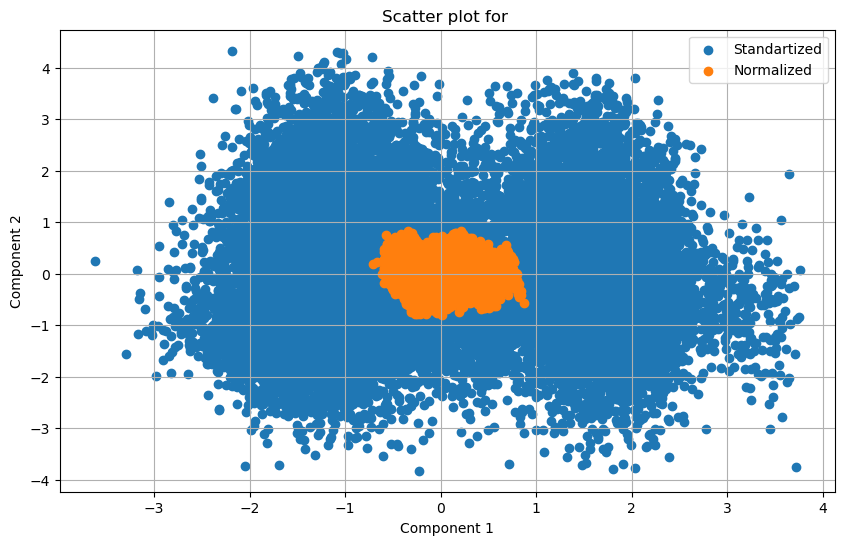

In [40]:
X_pca_s, X_pca_n = df_pca_s.drop(columns=['target']), df_pca_n.drop(columns=['target'])

plt.figure(figsize=(10,6))

plt.title(f'Scatter plot for ')

plt.scatter(X_pca_s['PCA_standard component 1'], X_pca_s['PCA_standard component 2'], label='Standartized')
plt.scatter(X_pca_n['PCA_normal component 1'], X_pca_n['PCA_normal component 2'], label='Normalized')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid()
plt.legend()
plt.show()  

### Задание 4. Применение Disciminant Analysis.

Используйте набор данных "Iris" из sklearn.datasets. Примените Linear Discriminant Analysis (LDA) и Quadratic Discriminant Analysis (QDA), чтобы снизить размерность до 2-х и визуализируйте результаты.

In [41]:
X, y = df_iris.drop(columns=['target']), df_iris.target

In [ ]:
n = 2

LDA = LinearDiscriminantAnalysis(n_components=n)
# QDA = QuadraticDiscriminantAnalysis()

LDA_components = LDA.fit_transform(X, y)
# X_qda = QDA.fit(X, y).predict(X)

,LDA component 1,LDA component 2,target
0,8.244437,0.472458,setosa
1,7.240384,-0.638711,setosa
2,7.598624,-0.171493,setosa
3,6.878187,-0.656115,setosa
4,8.308321,0.645717,setosa
5,7.933907,1.662622,setosa
6,7.314084,0.396485,setosa


In [45]:
df_lda = pd.DataFrame(data=LDA_components, columns=[f'LDA component {i}' for i in range(1, n + 1)])
df_lda['target'] = y

df_lda.head(7)

,LDA component 1,LDA component 2,target
0,8.244437,0.472458,setosa
1,7.240384,-0.638711,setosa
2,7.598624,-0.171493,setosa
3,6.878187,-0.656115,setosa
4,8.308321,0.645717,setosa
5,7.933907,1.662622,setosa
6,7.314084,0.396485,setosa


In [ ]:
# df_qda = pd.DataFrame(data=QDA_components, columns=[f'QDA component {i}' for i in range(1, n + 1)])
# df_qda['target'] = y

# df_qda.head(7)

,0,target
0,setosa,setosa
1,setosa,setosa
2,setosa,setosa
3,setosa,setosa
4,setosa,setosa
5,setosa,setosa
6,setosa,setosa


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


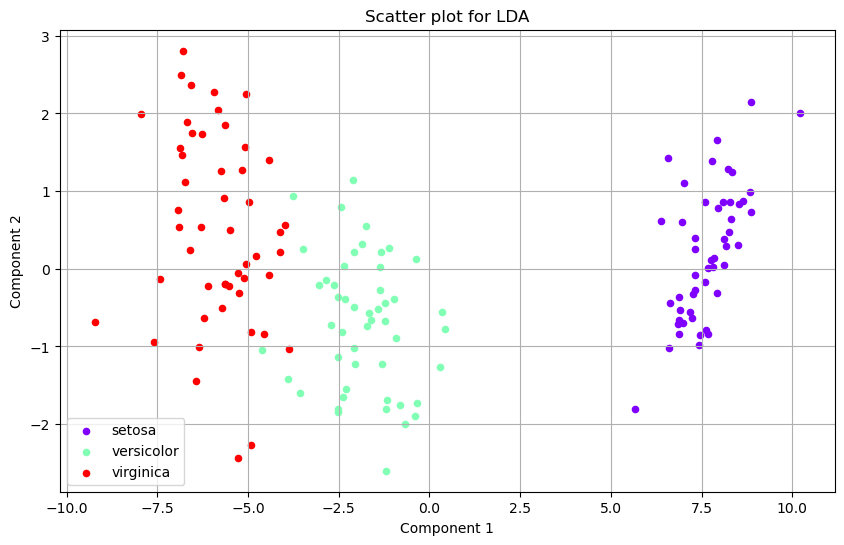

In [ ]:
visualize('LDA', df_lda, ds_iris.target_names) 

### Задание 5. Сравнение PCA и LDA.
Используйте любой набор данных с классифицирующей моделью. Примените PCA и LDA и сравните, как влияют эти методы снижения размерности на эффективность классификации.

In [ ]:
X, y = df_iris.drop(columns=['target']), df_iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
rfc = RandomForestClassifier()

X_pca = PCA(n_components=n).fit_transform(X, y)
X_lda = LinearDiscriminantAnalysis(n_components=n).fit_transform(X, y)

for X_method, name in zip([X, X_pca, X_lda], ['стандарт', 'PCA', 'LDA']):
    X_train, X_test, y_train, y_test = train_test_split(X_method, y, train_size=0.8)

    rfc.fit(X_train, y_train)

    cv = RepeatedStratifiedKFold(n_splits=5, random_state=42)

    scores = cross_val_score(rfc, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
    mean_accuracy = np.mean(scores)

    print(f'Результат кросс-валидации для {name}: ', mean_accuracy)

Результат кросс-валидации для стандарт:  0.9433333333333335
Результат кросс-валидации для PCA:  0.9433333333333335
Результат кросс-валидации для LDA:  0.9566666666666667


## Нелинейные методы.

### Задание 1. Применения метода t-SNE.
Используйте набор данных "Iris" из sklearn.datasets. Примените t-SNE, чтобы снизить размерность до 2-х, и визуализируйте результаты.

In [ ]:
X_embedded = TSNE(n_components=n, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

df_tsne = pd.DataFrame(data=X_embedded, columns=[f'tsne component {i}' for i in range(1, n + 1)])
df_tsne['target'] = df_iris.target

C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


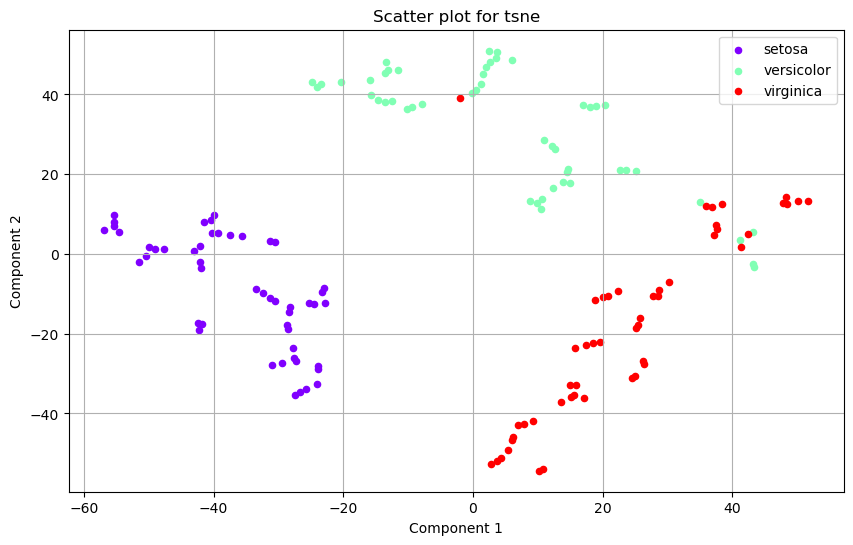

In [ ]:
visualize('tsne', df_tsne, ds_iris.target_names)

### Задание 2. Определение влияния параметров t-SNE.
Используйте тот же набор данных "Iris". Примените t-SNE с разными значениями параметров (например, число итераций, learning rate) и сравните полученные результаты.

Learning rate = 10, n_iter = 250.


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


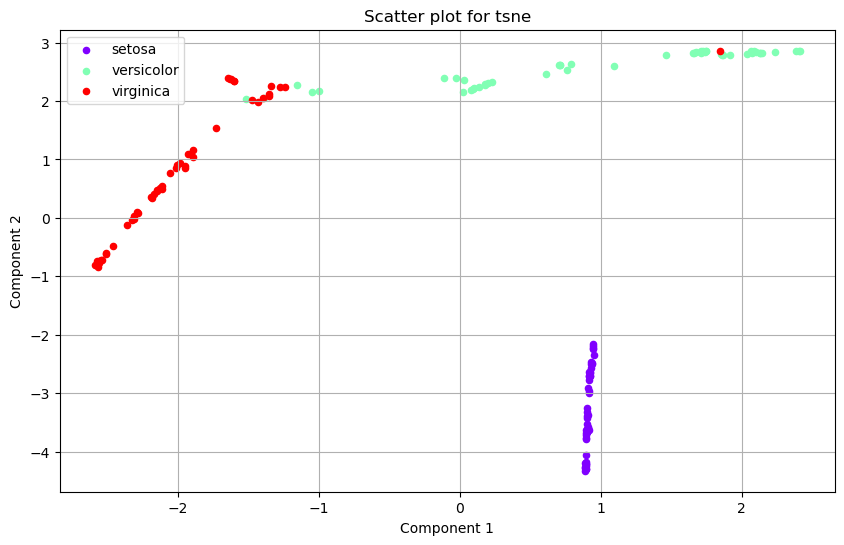

Learning rate = 10, n_iter = 500.


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


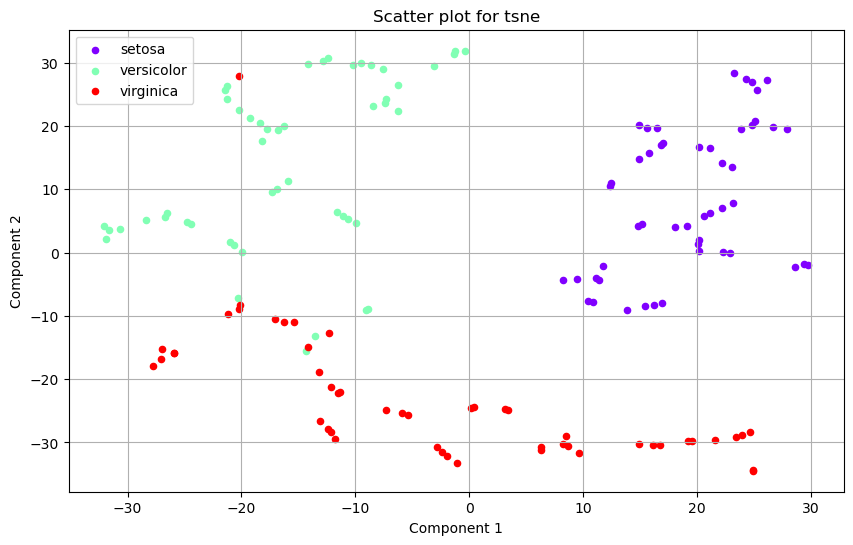

Learning rate = 110, n_iter = 250.


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


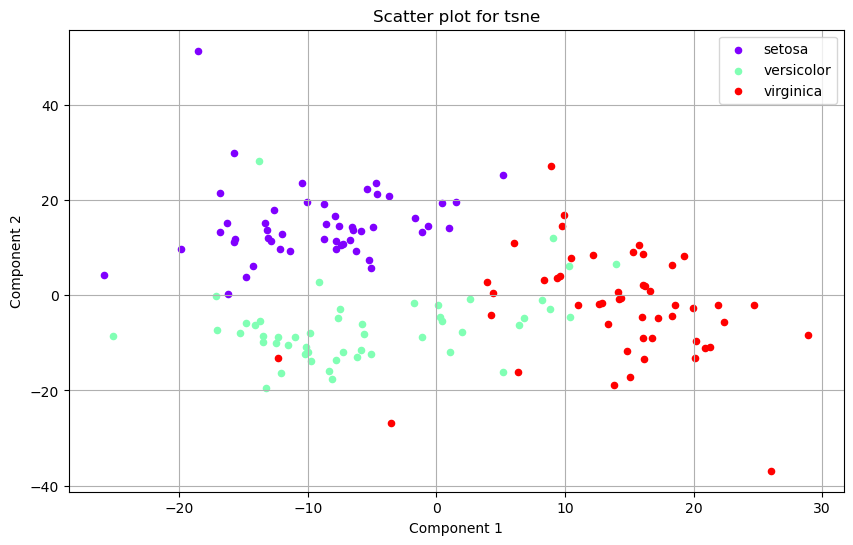

Learning rate = 110, n_iter = 500.


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


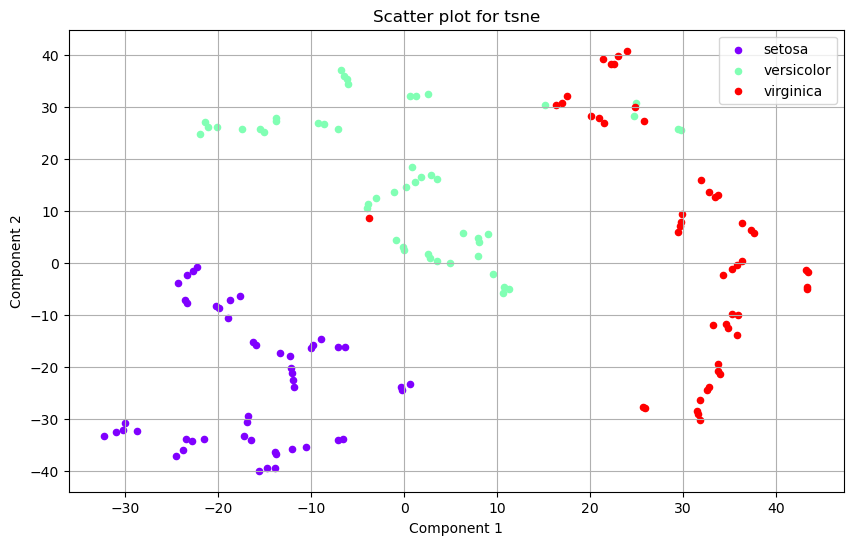

Learning rate = 210, n_iter = 250.


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


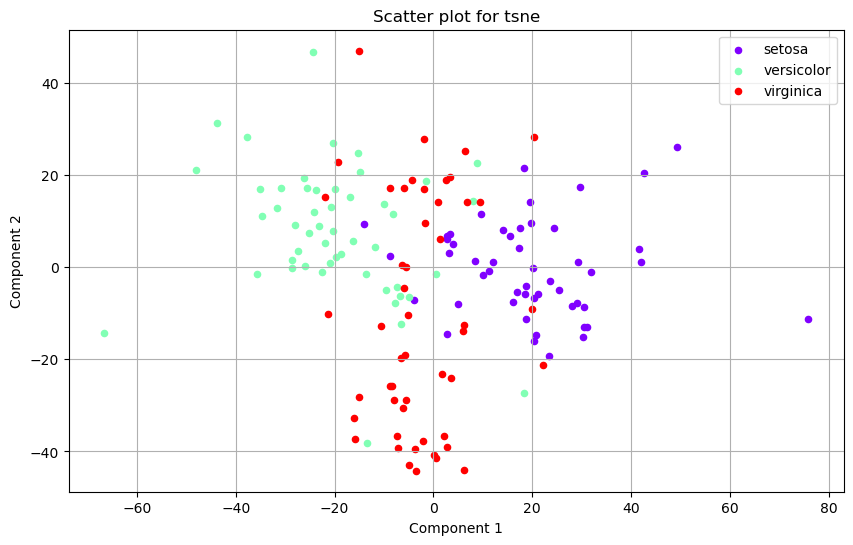

Learning rate = 210, n_iter = 500.


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


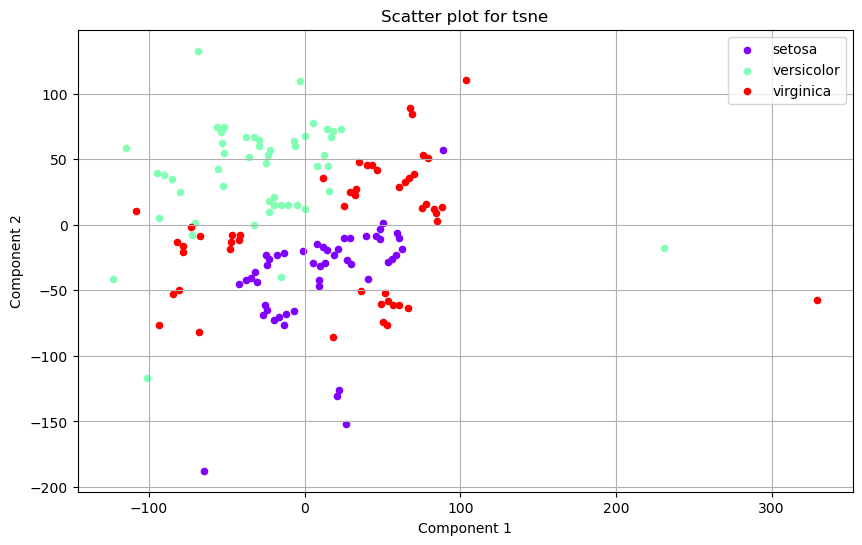

Learning rate = 310, n_iter = 250.


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


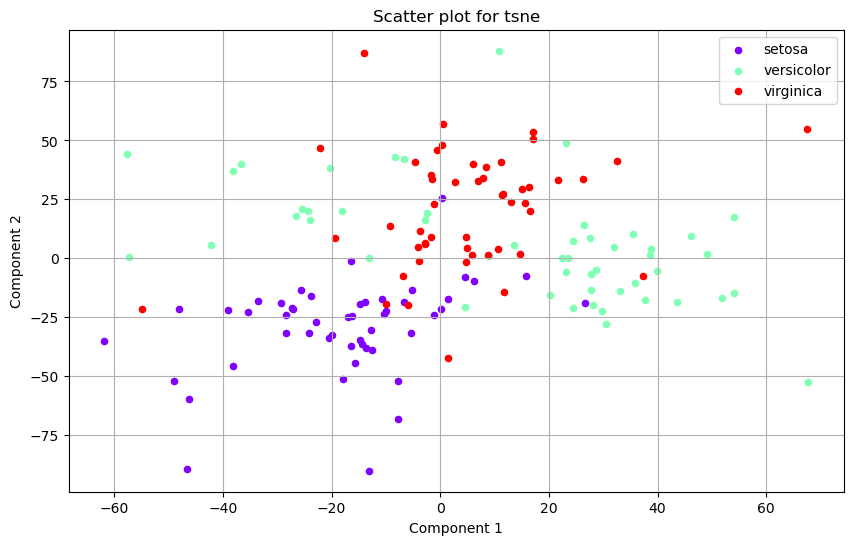

Learning rate = 310, n_iter = 500.


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


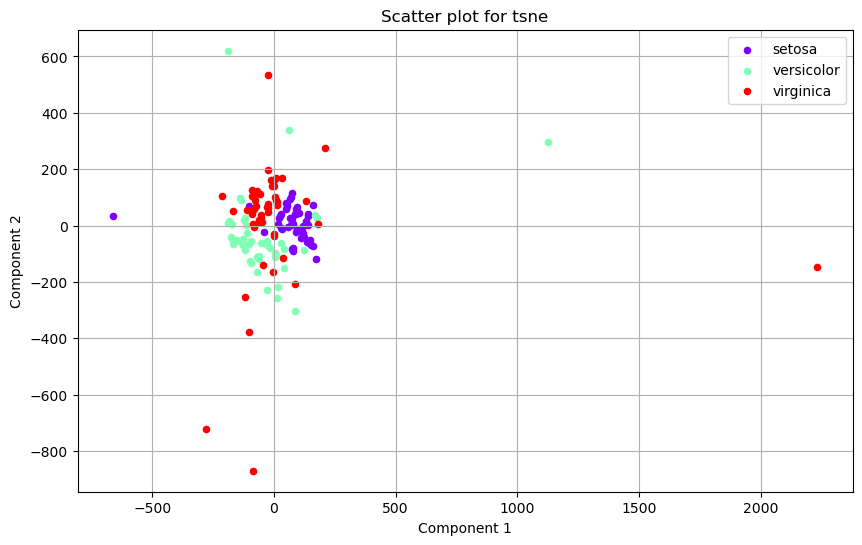

In [ ]:
for alpha in range(10, 311, 100):
    for n_it in range(250, 501, 250):
        X_embedded = TSNE(n_components=2, learning_rate=alpha, n_iter=n_it, init='random', perplexity=3).fit_transform(X)

        df_tsne = pd.DataFrame(data=X_embedded, columns=[f'tsne component {i}' for i in range(1, n + 1)])
        df_tsne['target'] = df_iris.target

        print(f'Learning rate = {alpha}, n_iter = {n_it}.')
        visualize('tsne', df_tsne, ds_iris.target_names)

### Задание 3. Сравнение t-SNE и PCA.
Используйте любой набор данных на ваше усмотрение. Примените PCA и t-SNE, чтобы снизить размерность до 2-х, и сравните разницы в результатах визуализации.

In [ ]:
X, y = df_wine.drop(columns=['target']), df_wine.target

C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


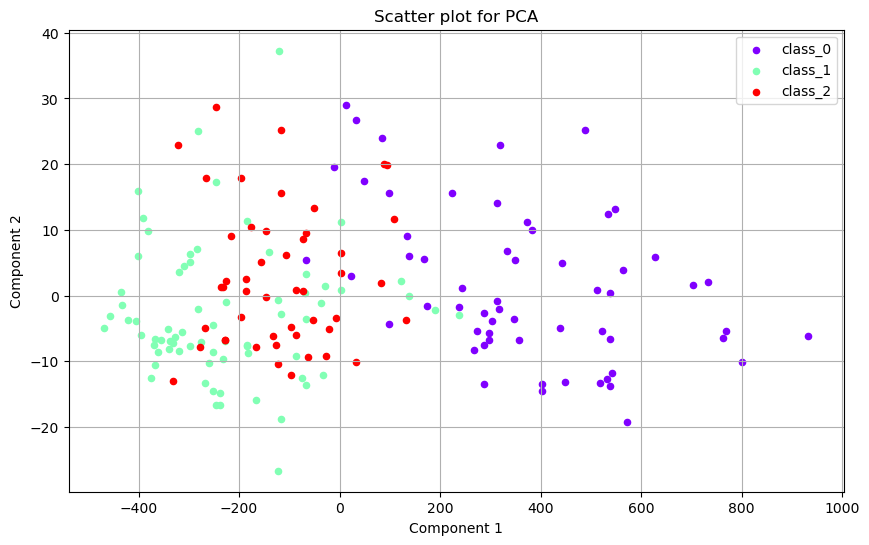

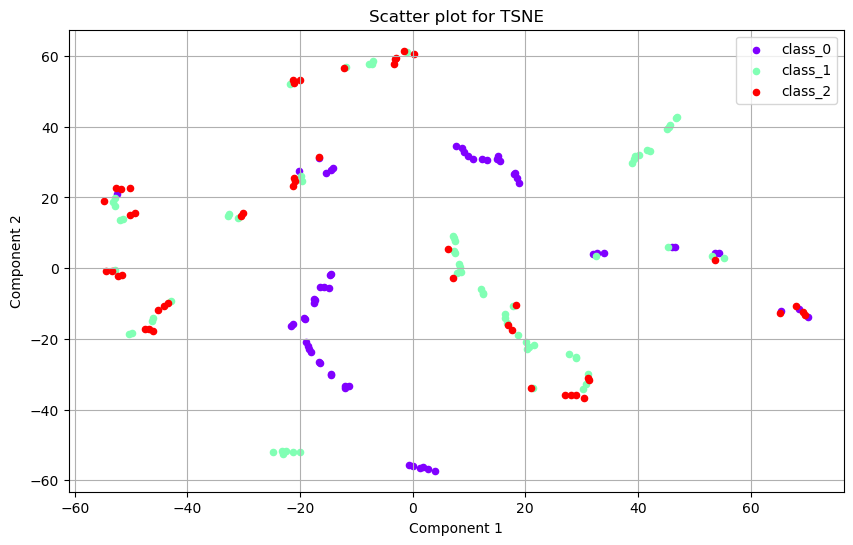

In [ ]:
X_pca = PCA(n_components=n).fit_transform(X, y)
X_tsne = TSNE(n_components=n, learning_rate='auto', init='random', perplexity=3).fit_transform(X, y)

df_pca = pd.DataFrame(data=X_pca, columns=[f'PCA component {i}' for i in range(1, n + 1)])
df_pca['target'] = y

df_tsne = pd.DataFrame(data=X_tsne, columns=[f'TSNE component {i}' for i in range(1, n + 1)])
df_tsne['target'] = y

visualize('PCA', df_pca, ds_wine.target_names)
visualize('TSNE', df_tsne, ds_wine.target_names)

### Задание 4. Применение UMAP.
Используйте набор данных "MNIST" (например, содержащийся в sklearn.datasets). Примените UMAP для снижения размерности и визуализируйте результаты.

In [ ]:
ds_mnist = fetch_openml('mnist_784', version=1)

X, y = ds_mnist.data, ds_mnist.target

In [ ]:
X_umap = umap.UMAP(random_state=42).fit_transform(X)

df_umap = pd.DataFrame(data=X_umap, columns=[f'UMAP component {i}' for i in range(1, n + 1)])
df_umap['target'] = y

df_umap.head(7)

c:\Users\Morzhig\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,UMAP component 1,UMAP component 2,target
0,3.426520,4.896139,5
1,15.682005,5.786432,0
2,1.150015,14.526500,4
3,-4.314825,1.335926,1
4,-0.803665,11.106213,9
5,4.294667,-0.799116,2
6,-1.377259,-4.203629,1


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


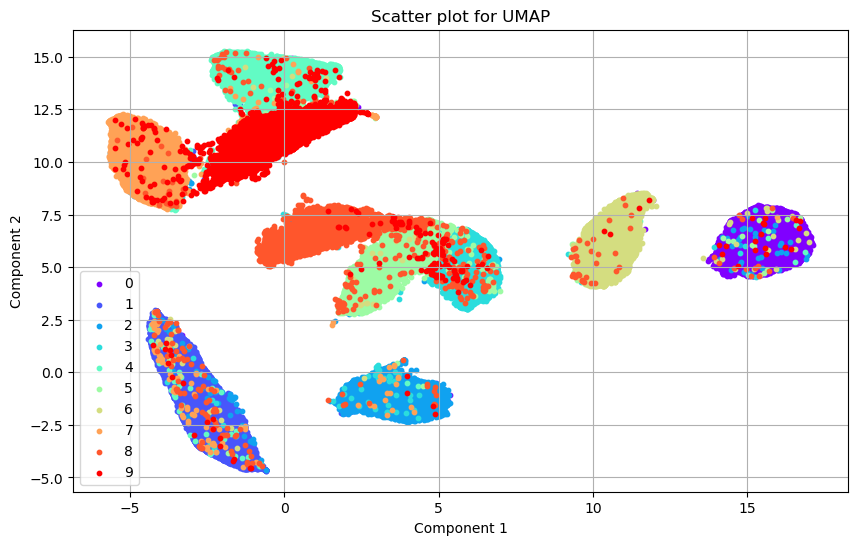

In [ ]:
visualize('UMAP', df_umap, sorted(ds_mnist.target.unique()), s_=10)

### Задание 5. Сравнение UMAP и t-SNE.
Используйте один и тот же набор данных для применения UMAP и t-SNE. Сравните влияние этих методов снижения размерности на визуальное разделение классов в данных.

In [ ]:
X, y = df_iris.drop(columns=['target']), df_iris.target

X_umap = umap.UMAP(random_state=42).fit_transform(X)

df_umap = pd.DataFrame(data=X_umap, columns=[f'UMAP component {i}' for i in range(1, n + 1)])
df_umap['target'] = y

df_umap.head(7)

c:\Users\Morzhig\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,UMAP component 1,UMAP component 2,target
0,24.162060,7.414579,setosa
1,24.143291,5.441109,setosa
2,23.604923,5.685467,setosa
3,23.498585,5.518656,setosa
4,24.030851,7.503886,setosa
5,24.665455,8.086985,setosa
6,23.364428,5.959329,setosa


In [ ]:
X_tsne = TSNE().fit_transform(X)

df_tsne = pd.DataFrame(data=X_tsne, columns=[f'TSNE component {i}' for i in range(1, n + 1)])
df_tsne['target'] = y

df_tsne.head(7)

,TSNE component 1,TSNE component 2,target
0,-23.056255,-2.370046,setosa
1,-25.453648,-2.772681,setosa
2,-25.928423,-2.026993,setosa
3,-25.996340,-1.649071,setosa
4,-22.935839,-1.890281,setosa
5,-21.046217,-1.984611,setosa
6,-25.602917,-1.135995,setosa


C:\Users\Morzhig\AppData\Local\Temp\ipykernel_18000\4037935105.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, label=target, s=s_)


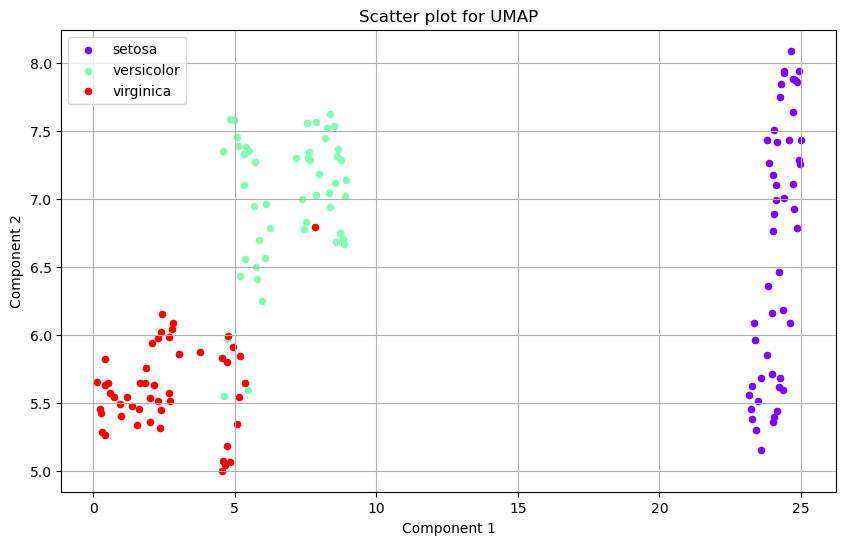

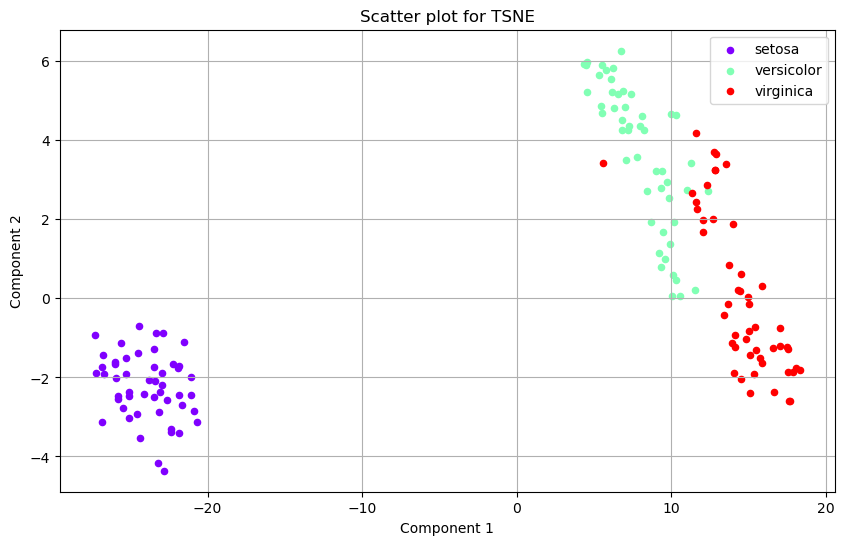

In [ ]:
visualize('UMAP', df_umap, ds_iris.target_names)
visualize('TSNE', df_tsne, ds_iris.target_names)